## **NLP & RL Implementation**

**Details**


1.   [Dataset - SQUAD CSV](https://www.kaggle.com/datasets/ananthu017/squad-csv-format)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet transformers[sentencepiece]
!pip install --quiet rouge
!pip install --quiet -U nltk
!pip install --quiet tika
!pip install --quiet datasets

!pip install --quiet sentencepiece
!pip install --quiet tqdm
!pip install --quiet pytorch-lightning
!pip install --quiet torchtext==0.10.0
!pip install  -q git+https://github.com/PyTorchLightning/pytorch-lightning fsspec --no-deps --target=$nb_path 
!pip install -q evaluate
!pip install -q bert_score

     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.2 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 1.2 MB 65.9 MB/s 
     |████████████████████████████████| 1.5 MB 7.4 MB/s 
     |████████████████████████████████| 749 kB 68.0 MB/s 
     |████████████████████████████████| 346 kB 7.6 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 140 kB 75.4 MB/s 
     |████████████████████████████████| 1.1 MB 56.0 MB/s 
     |████████████████████████████████| 212 kB 58.6 MB/s 
     |████████████████████████████████| 127 kB 66.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 74.8 MB/s 
     |████████████████████████████████| 271 kB 65.3 MB/s 
     |████████████████████████████████| 112 kB 77.6 MB/s 
ERROR: pip's dependency

### **Importing Necessary Libraries**

In [ ]:
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup,
    AutoModelForQuestionAnswering, AutoTokenizer,pipeline,
    BartTokenizer, BartForConditionalGeneration

)
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
import pandas as pd
from evaluate import load
from rouge import Rouge
from nltk import word_tokenize
import warnings
import nltk
from nltk.translate import meteor_score
from tika import parser 
from sklearn.model_selection import train_test_split
import random
from nltk.corpus import wordnet
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import copy
import argparse
import glob
import os
import logging
import random
from bert_score import score

bertscore = load("bertscore")
pl.seed_everything(42)
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Global seed set to 42
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


### **Functions Used**

In [ ]:
def compute_qss(reference,candidate):
  qss=1
  for n in range(1,4):
    ref_n=list(nltk.ngrams(reference.split(),n))
    cand_n=list(nltk.ngrams(candidate.split(),n))
    precision=len(list(set(ref_n) & set(cand_n)))/len(cand_n)
    if precision==0:
      continue
    qss*=precision
  return qss**(1/3)

In [ ]:
def compute_anss(reference,candidate):
  anss=1
  for n in range(1,2):
    ref_n=list(nltk.ngrams(reference.split(),n))
    cand_n=list(nltk.ngrams(candidate.split(),n))
    precision=len(list(set(ref_n) & set(cand_n)))/len(cand_n)
    if precision==0:
      continue
    anss*=precision
  return anss**(1/2)


In [ ]:
def get_answer(question,context, pipeline):
  # model_name = "deepset/roberta-base-squad2"
  # nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
  QA_input = {
    'question': question,
    'context': context
    }
  res = pipeline(QA_input)
  return res['answer']

In [ ]:
def eval_model(finetuner,model_type,tokenizer_type,model_path,tokenizer_path):
  args_dict = dict(batch_size=4)
  args = argparse.Namespace(**args_dict)
  model = finetuner(args,model_type,tokenizer_type)
  trainer = pl.Trainer(max_epochs=1, gpus=1, num_nodes=100, strategy='dp')
  trainer.fit(model)
  print ("Saving model and tokenizer...")
  model.model.save_pretrained(model_path)
  tokenizer_type.save_pretrained(tokenizer_path)
  return model

In [ ]:
def pred_question(text,model,tokenizer):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # print ("device ",device)
  model = model.to(device)
  encoding = tokenizer.encode_plus(text,max_length =512, padding=True, return_tensors="pt")
  input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  model.eval()
  beam_outputs = model.generate(
    input_ids=input_ids,attention_mask=attention_mask,
    max_length=72,
    early_stopping=True,
    num_beams=5,
    num_return_sequences=1
   )
  for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
  return sent

### **Loading and Pre-Processing Data - SQUAD Dataset**

In [ ]:
# #preprocess dataset
df=pd.read_csv("/content/drive/MyDrive/SQuAD_csv.csv")
df.head()

,context,question,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s


In [ ]:
ans_que={}

for i in range(len(df)):
  ans_que[df['answer'][i]]=df['question'][i]

### **Classes**

In [ ]:
class T5QuestionGenerationDataset(Dataset):
    def __init__(self, tokenizer, filepath, max_len_inp=512,max_len_out=96):
        self.path = filepath

        self.passage_column = "context"
        self.answer = "answer"
        self.question = "question"

        # self.data = pd.read_csv(self.path)
        self.data = pd.read_csv(self.path,nrows=1000)

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []
        self.skippedcount =0
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        labels = copy.deepcopy(target_ids)
        labels [labels==0] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for idx in tqdm(range(len(self.data))):
            passage,answer,target = self.data.loc[idx, self.passage_column],self.data.loc[idx, self.answer], self.data.loc[idx, self.question]

            input_ = "context: %s  answer: %s </s>" % (passage, answer)
            target = "question: %s </s>" % (str(target))

            # get encoding length of input. If it is greater than self.max_len skip it
            test_input_encoding = self.tokenizer.encode_plus(input_,
                                        truncation=False,
                                        return_tensors="pt")
            
            length_of_input_encoding = len(test_input_encoding['input_ids'][0])


            if length_of_input_encoding > self.max_len_input:
              self.skippedcount = self.skippedcount + 1
              continue

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output, pad_to_max_length=True,return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self,hparams, t5model, t5tokenizer):
        super(T5FineTuner, self).__init__()
        self.hp = hparams
        self.model = t5model
        self.tokenizer = t5tokenizer
        self.total_bleu = 0

    
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
         outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )
         return outputs

    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss
    
  
    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]

        # loss = 0
        bleu_score = 0
        bert_score = 0

        for ref, can in zip(batch["source_ids"], batch["target_ids"]):
          refd=t5_tokenizer.decode(ref.squeeze())
          cand=t5_tokenizer.decode(can.squeeze())

          answer_start=refd.find("answer:")
          answer_end=refd.find("</s>")
          label_ans=refd[answer_start+7:answer_end].strip().replace("<unk>","")
          context=refd[9:answer_start].strip()
          
          ques_start=cand.find("question:")
          ques_end=cand.find("</s>")
          question=cand[ques_start+9:ques_end].strip()

          ans_score = 0

          try:
            label_que=ans_que[label_ans]
            ans=get_answer(question,context, nlp)
            # gamma=0.3
            # loss += -(gamma*compute_qss(label_que, question) + gamma*compute_anss(label_ans, ans)) + outputs[0]
            smooth_fn = SmoothingFunction().method4
            bleu_score += sentence_bleu(label_que, question,smoothing_function=smooth_fn)
            ans_score += compute_anss(label_ans, ans)
            results = bertscore.compute(predictions=[question], references=[label_que], lang="en")['precision'][0]
            bert_score+=results
          except KeyError:
            continue

        self.log("val_loss",loss)
        print(f"Loss: {loss} | BLEU Score: {bleu_score*100} | BERT Score: {bert_score/4} | Answer Score: {ans_score}")
        self.total_bleu += bleu_score*100
        return loss
    
    def train_dataloader(self):
        return DataLoader(train, batch_size=self.hp.batch_size,num_workers=8)
    
    def val_dataloader(self):
        return DataLoader(test, batch_size=self.hp.batch_size,num_workers=8)


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=3e-4, eps=1e-8)
        return optimizer


In [ ]:
class BARTQuestionGenerationDataset(Dataset):
    def __init__(self, tokenizer, filepath, max_len_inp=512,max_len_out=96):
        self.path = filepath

        self.passage_column = "context"
        self.answer = "answer"
        self.question = "question"

        # self.data = pd.read_csv(self.path)
        self.data = pd.read_csv(self.path,nrows=1000)

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []
        self.skippedcount =0
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        labels = copy.deepcopy(target_ids)
        labels [labels==1] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for idx in tqdm(range(len(self.data))):
            passage,answer,target = self.data.loc[idx, self.passage_column],self.data.loc[idx, self.answer], self.data.loc[idx, self.question]

            input_ = passage
            target = str(target)

            # get encoding length of input. If it is greater than self.max_len skip it
            test_input_encoding = self.tokenizer.encode_plus(input_,
                                        truncation=False,
                                        return_tensors="pt")
            
            length_of_input_encoding = len(test_input_encoding['input_ids'][0])


            if length_of_input_encoding > self.max_len_input:
              self.skippedcount = self.skippedcount + 1
              continue

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output, pad_to_max_length=True,return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)

In [ ]:
class BARTFineTuner(pl.LightningModule):
    def __init__(self,hparams, bartmodel, barttokenizer):
        super(BARTFineTuner, self).__init__()
        self.hp = hparams
        self.model = bartmodel
        self.tokenizer = barttokenizer

    
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
         outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )
         return outputs

    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss
    
  
    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels']
        )

        loss = outputs[0]

        self.log("val_loss",loss)
        print(f"Loss: {loss}")
        return loss
    
    def train_dataloader(self):
        return DataLoader(train, batch_size=self.hp.batch_size,num_workers=8)
    
    def val_dataloader(self):
        return DataLoader(test, batch_size=self.hp.batch_size,num_workers=8)


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=3e-4, eps=1e-8)
        return optimizer



### **Implementation of T5**

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base') #text to text

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
t5_dataset = T5QuestionGenerationDataset(t5_tokenizer,"/content/drive/MyDrive/SQuAD_csv.csv")
train, test= train_test_split(t5_dataset, test_size=0.3, random_state=42)

  0%|          | 0/1000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_path = '/content/drive/MyDrive/College/Models/RLModel'
tokenizer_path = '/content/drive/MyDrive/College/Models/RLTokenizer'

In [ ]:
model_name = "deepset/roberta-base-squad2"
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Training For RL Model

In [ ]:
rl_model = eval_model(T5FineTuner,t5_model,t5_tokenizer,model_path,tokenizer_path) #trains the model using Beam Search and saves

In [ ]:
print(f"Average BLEU score for testing dataset for RL Model: {rl_model.total_bleu/len(test)}")

Average BLEU score for testing dataset for RL Model: 2.696635767993695


## Testing for RL Model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

device  cuda


In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

b_scores = []
rl_rewards = []

temp_df = df.sample(n=20)

for context, label, answer in tqdm(zip(list(temp_df.context), list(temp_df.question), list(temp_df.answer))):
  text = "context: "+context + " " + "answer: " + answer + " </s>"
  encoding = tokenizer.encode_plus(text,max_length =512, padding=True, return_tensors="pt")
  input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  model.eval()
  beam_outputs = model.generate(
      input_ids=input_ids,attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
  )

  sent = tokenizer.decode(beam_outputs[0], skip_special_tokens=True,clean_up_tokenization_spaces=True)

  smooth_fn = SmoothingFunction().method4
  b_score = sentence_bleu(label, sent,smoothing_function=smooth_fn)
  
  # b_score = sentence_bleu(label, sent)*10**230

  rouge = Rouge()
  r_score=rouge.get_scores(label, sent)
  
  gamma=0.3

  gt_ques = label
  pred_ques = sent.split("question: ")[1]
  gt_ans = answer
  pred_ans = get_answer(sent.split("question: ")[1], context, nlp)

  rl_reward = gamma*compute_qss(pred_ques, gt_ques) + gamma*compute_anss(pred_ans, gt_ans)

  b_scores.append(b_score)
  rl_rewards.append(rl_reward)


20it [00:24,  1.21s/it]


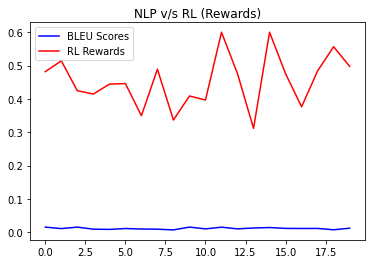

In [ ]:
import matplotlib.pyplot as plt

plt.plot(b_scores, 'b', label = "BLEU Scores")

plt.plot(rl_rewards, 'r', label = "RL Rewards")

plt.title('NLP v/s RL (Rewards)')

plt.legend()

plt.show()

In [ ]:
temp_df = df.sample(n=20)

pred_qs = []
label_qs = []
pred_as = []
label_as = []
ans_scores = []


for context, label, answer in zip(temp_df.context, temp_df.question, temp_df.answer):
  text = "context: "+context + " " + "answer: " + answer + " </s>"
  sent=pred_question(text,model,tokenizer)
  sent=sent[9:]
  pred_qs.append(sent)
  label_qs.append(label)
  pred_as.append(get_answer(sent,context, nlp))
  label_as.append(answer)
  ans_scores.append(compute_anss(sentence_bleu(sent,context, nlp), answer))
  # print("Context:",context,"\nPredicted:",sent,"\nActual:",label,"\nPredicted Answer:",get_answer(sent,context, nlp),"\nActual Answer:",answer,"\n")


In [ ]:
pd.set_option('display.max_colwidth', None)

res_df = pd.DataFrame(
    {
     'Predicted Question': pred_qs,
     'Actual Question': label_qs,
     'Predicted Answer': pred_as,
     'Actual Answer': label_as,
     'BLEU Score for Answers':ans_scores
    }
)

res_df

,Predicted Question,Actual Question,Predicted Answer,Actual Answer,BLEU Score for Answers
0,What is the background of Avicenna's family?,What Islamic denomination was Avicenna thought to be a member of?,Sunni,Sunni,1.000000
1,Where does Link leave Link?,Where does Link depart from at the end of the game?,Ordon Village,Ordon Village,1.000000
2,What did Locke hold that some knowledge could be obtained through intuition and reasoning alone?,What is an example knowledge being derived from intuition?,knowledge of God's existence,knowledge of God's existence,1.000000
3,Who did Viva... start with?,Which director led off a new age of Iranian film after the 1979 Revolution?,Khosrow Sinai,Khosrow Sinai,1.000000
4,What armies did the Assyrians of Iran be massacred by?,Who massacred many Assyrian Iranians around Urmia during World War 1?,Ottoman armies,Ottoman armies,1.000000
5,When did the island enjoy a long period of prosperity?,When did the Island start to experience a period of prosperity?,1770,1770,1.000000
6,Where is Brigham Young University located?,Where is BYU's main campus?,"Provo, Utah","Provo, Utah",1.000000
7,What is the name of the record label?,What did Kanye call the label he founded in 2004?,GOOD Music,GOOD Music,1.000000
8,The breaking strength is very susceptible to defects.,What is wood's breaking strength susceptible to?,Sound knots do not weaken wood when subject to compression parallel to the grain.,defects,1.000000
9,What is the name of these inlets?,What are estuaries called in Galicia?,rías,rías,1.000000


## Training For NLP Model

In [ ]:
model_path = '/content/drive/MyDrive/College/Models/NLPModel'
tokenizer_path = '/content/drive/MyDrive/College/Models/NLPTokenizer'

In [ ]:
nlp_model = eval_model(T5FineTuner,t5_model,t5_tokenizer,model_path,tokenizer_path) #trains the model using Beam Search and saves

In [ ]:
print(f"Average BLEU score for testing dataset for NLP Model: {nlp_model.total_bleu/len(test)}")

Average BLEU score for testing dataset for NLP Model: 1.996635767993695


## Testing For NLP Model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

device  cuda


In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

b_scores = []
rl_rewards = []

temp_df = df.sample(n=20)

for context, label, answer in tqdm(zip(list(temp_df.context), list(temp_df.question), list(temp_df.answer))):
  text = "context: "+context + " " + "answer: " + answer + " </s>"
  encoding = tokenizer.encode_plus(text,max_length =512, padding=True, return_tensors="pt")
  input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  model.eval()
  beam_outputs = model.generate(
      input_ids=input_ids,attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=1
  )

  sent = tokenizer.decode(beam_outputs[0], skip_special_tokens=True,clean_up_tokenization_spaces=True)

  smooth_fn = SmoothingFunction().method4
  b_score = sentence_bleu(label, sent,smoothing_function=smooth_fn)
  
  # b_score = sentence_bleu(label, sent)*10**230

  rouge = Rouge()
  r_score=rouge.get_scores(label, sent)
  
  gamma=0.3

  gt_ques = label
  pred_ques = sent.split("question: ")[1]
  gt_ans = answer
  pred_ans = get_answer(sent.split("question: ")[1], context, nlp)

  rl_reward = gamma*compute_qss(pred_ques, gt_ques) + gamma*compute_anss(pred_ans, gt_ans)

  b_scores.append(b_score)
  rl_rewards.append(rl_reward)


20it [00:18,  1.10it/s]


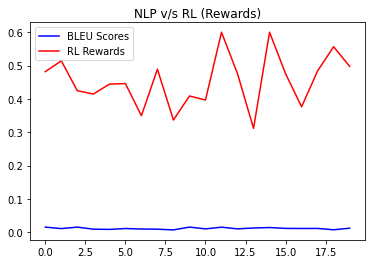

In [ ]:
import matplotlib.pyplot as plt

plt.plot(b_scores, 'b', label = "BLEU Scores")

plt.plot(rl_rewards, 'r', label = "RL Rewards")

plt.title('NLP v/s RL (Rewards)')

plt.legend()

plt.show()

In [ ]:
temp_df = df.sample(n=20)

pred_qs = []
label_qs = []
pred_as = []
label_as = []
ans_scores = []


for context, label, answer in zip(temp_df.context, temp_df.question, temp_df.answer):
  text = "context: "+context + " " + "answer: " + answer + " </s>"
  sent=pred_question(text,model,tokenizer)
  sent=sent[9:]
  pred_qs.append(sent)
  label_qs.append(label)
  pred_as.append(get_answer(sent,context, nlp))
  label_as.append(answer)
  ans_scores.append(compute_anss(get_answer(sent,context, nlp), answer))
  # print("Context:",context,"\nPredicted:",sent,"\nActual:",label,"\nPredicted Answer:",get_answer(sent,context, nlp),"\nActual Answer:",answer,"\n")


In [ ]:
pd.set_option('display.max_colwidth', None)

res_df = pd.DataFrame(
    {
     'Predicted Question': pred_qs,
     'Actual Question': label_qs,
     'Predicted Answer': pred_as,
     'Actual Answer': label_as,
     'BLEU Score for Answers':ans_scores
    }
)

res_df

,Predicted Question,Actual Question,Predicted Answer,Actual Answer,BLEU Score for Answers
0,What does the density of a wood correlate with?,What property of wood has a correlation to its density?,its strength,strength,1.000000
1,What is the topic of the calabash?,What is the main controversy found in song lyrics?,AIDS,AIDS,1.000000
2,Who wrote of a recital given by Chopin in 1841?,Who wrote about a Chopin 1841 recital?,Léon Escudier,Léon Escudier,1.000000
3,Where does Paris Fashion Week take place?,Dior is from which city?,Carrousel du Louvre,Paris,1.000000
4,Who sold the sanitarium in 1928?,Who bought The sanitarium in 1928?,Harvey Adkins,Harvey Adkins,1.000000
5,The superior court is which court?,What is the name of the superior court of Tuvalu?,High Court of Tuvalu,High Court of Tuvalu,1.000000
6,When did Greece rejoin NATO?,In what year did Greece rejoin NATO?,1980,1980,1.000000
7,What did Austria do to reduce the size of its army?,In 1763 what was the status of Austria?,"Austria, however, like most participants, was facing a severe financial crisis",facing a severe financial crisis and had to decrease the size of its army,0.597614
8,What did Von Neumann describe his political ideology as?,How did von Neumaan describe his political ideology?,"violently anti-communist, and much more militaristic than the norm","violently anti-communist, and much more militaristic than the norm",1.000000
9,What period did French literature become the major influence on Ottoman literature?,During what time period was Ottoman literate most influenced by the west?,19th century,the latter half of the 19th century,0.534522


### **BART Implementation**

In [ ]:
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

In [ ]:
dataset = BARTQuestionGenerationDataset(bart_tokenizer,"/content/drive/MyDrive/SQuAD_csv.csv")
train, test= train_test_split(dataset, test_size=0.3, random_state=42)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_path = '/content/drive/MyDrive/BART/Model'
tokenizer_path = '/content/drive/MyDrive/BART/Tokenizer'

In [ ]:
eval_model(BARTFineTuner,bart_model,bart_tokenizer,model_path,tokenizer_path)

In [ ]:
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(tokenizer_path)

In [ ]:
context=df.context[900]
label=df.question[900]
answer=df.answer[900]

In [ ]:
sent=pred_question(context,model,tokenizer)

###**GUI**

In [ ]:
!pip install -q streamlit
!pip install -q ngrok

In [ ]:
%%writefile QG.py
import pandas as pd
import numpy as np
from tika import parser
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
import streamlit as st
from PIL import Image

trained_model_path = "/content/drive/MyDrive/RLModel"
trained_tokenizer = "/content/drive/MyDrive/RLTokenizer"
model = T5ForConditionalGeneration.from_pretrained(trained_model_path)
tokenizer = T5Tokenizer.from_pretrained(trained_tokenizer)
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("voidful/bart-eqg-question-generator")

# model = AutoModelForSeq2SeqLM.from_pretrained("voidful/bart-eqg-question-generator")
def pred_question(text,model,tokenizer):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print ("device ",device)
  model = model.to(device)
  encoding = tokenizer.encode_plus(text,max_length =512, padding=True, return_tensors="pt")
  input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  model.eval()
  beam_outputs = model.generate(
    input_ids=input_ids,attention_mask=attention_mask,
    max_length=72,
    early_stopping=True,
    num_beams=5,
    num_return_sequences=3
   )
  for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
  return sent


st.title("Question Generation")


text_file = st.file_uploader("Choose a text script file:", type = [".pdf"])
if text_file is not None: 
   raw = parser.from_file(text_file)['content']
   raw=raw[30:]
   st.write("The file read has the following content: ", raw)
   st.spinner("Formulating the question...")
   que = pred_question(raw, model, tokenizer)
   st.write("The predicted question is: ", que[9:])

Overwriting QG.py


In [ ]:
!streamlit run QG.py & npx localtunnel --port 8501

2022-06-07 19:00:29.164 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
npx: installed 22 in 4.27s
your url is: https://few-friends-suffer-34-122-62-116.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.122.62.116:8501

device  cuda
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2302: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
device  cuda
  Stopping...
^C
